<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_23/blob/main/Assignments/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#$\color{blue}{\text{Name-Surname: Emre Beray Boztepe}}$
#$\color{blue}{\text{Student Number: 350227}}$

# Lab Assignment 4

**Submission deadline:**
* **lab session in the week 18-22.12.23**

**Points: 1+2+1 points**


In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [ ]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm
from matplotlib import animation, pyplot, rc

import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# Logistic Regression

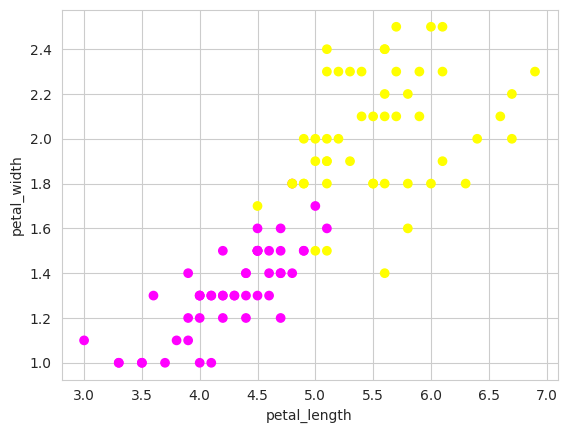

In [ ]:
iris = datasets.load_iris()
petal_length = iris.data[:, iris.feature_names.index("petal length (cm)")].reshape(-1, 1)
petal_width = iris.data[:, iris.feature_names.index("petal width (cm)")].reshape(-1, 1)

#get rid of setosa targets
petal_length = petal_length[iris.target != 0, :]
petal_width  = petal_width[iris.target != 0, :]
iris_type    = iris.target[iris.target != 0] - 1

plt.scatter(petal_length, petal_width, c=iris.target[iris.target != 0], cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.show()

### Logistic Regressoin intuitions

Looking at the Iris scaterplot, we intuitively see that we could draw a line which approximately separates the Versicolors from Virginicas. While it will not correctly classify all flowers near the boundary region, it will do a decent job for the more distant ones.

One such guesstimated line may be $\text{petal_length} + \text{petal_width} - 6.5=0$.

(0.0, 3.0)


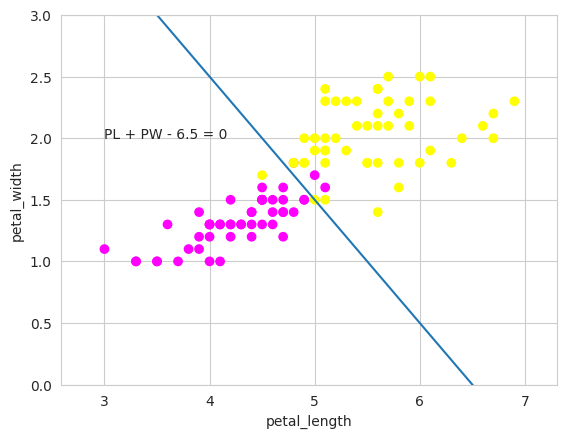

In [ ]:
# Extract the petal_length and petal_width of versicolors and virginicas
IrisX = np.hstack([np.ones_like(petal_length), petal_length, petal_width])

# Set versicolor=0 and virginia=1
IrisY = iris_type.reshape(-1, 1).astype(np.float64)

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
ylim = (0.0, 3.)
print(ylim)

# Guesstimate a separation boundary
plt.plot(plt.xlim(), 6.5 - np.array(plt.xlim()))
plt.ylim(*ylim)
_ = plt.text(3,2,"PL + PW - 6.5 = 0")

### Regression with a squashing function

Getting back to classification problem, we want to model the conditional probability
$$
p(\text{class}|\text{petal length}, \text{petal width}) = p(y|x)
$$

This conditional probability should depend on the distance of a point to the separating boundary. Points near the separating line are ambiguous - probablity there should be close to 0.5. On the other hand, the model should be fairly certain on points far away from the separating boundary.

We thus need to squash the distance from the boundary to the $0-1$ range of valid probabilities. We will accomplish this by mapping the distance through a "sigmoid" (meaning S-shaped function). A very popular function is the logistic sigmoid:
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

Text(0.5, 1.0, 'The logistic sigmoid function')

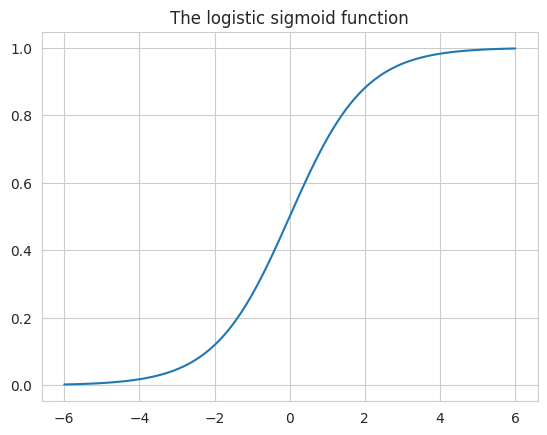

In [ ]:
z = np.linspace(-6,6,100)
plt.plot(z, 1/(1+np.exp(-z)))
plt.title('The logistic sigmoid function')

### Properties of the logistic sigmoid

The logistic sigmoif has a few nice properties:

1. $\sigma(0) = 0.5$. This means that points exaclt on the separating line are ambigous, just like we desired.
2. $\lim_{z\rightarrow \infty} \sigma(z) = 1$ and $\lim_{z\rightarrow -\infty} \sigma(z) = 0$: the further we are from the separating boundary, the more confident the model.
3. $\sigma(-z) = 1 - \sigma(z)$. The function is symmetrical, it doesn't matter which class we treat as the "positive" one.

### Definition of the Logistic Regression model

Armed with the $\sigma$ squashing function, let's define:

$$
p(y=1|x;\Theta) = \sigma(x\Theta),
$$
where $x$ is a row vector of features $y$ is a random variable denoting the target class and $\Theta$ is a column vector of model parameters.

**remark** In the scatter plot above the guesstimated line is represented by $\Theta$ equal to `[-6.5, 1., 1.]`.

Please observe that:

$$
\begin{align}
p(y=y^{(i)}|x^{(i)};\Theta) &= \cases{p(y=1|x^{(i)};\Theta) &if $y^{(i)}=1$ \\ 1-p(y=1|x^{(i)};\Theta) &if $y^{(i)}=0$}
\end{align}
$$

Therefore the cost function of the fitness of the model which we can use is:
$$
\begin{split}
J(\Theta) &= -\sum_{i=1}^{N} y^{(i)} \log \sigma(x^{(i)}\Theta) + (1-y^{(i)})\log(1-\sigma(x^{(i)}\Theta)) = \\
&= -\sum_{i=1}^{N}y^{(i)}\log p(y=1|x^{(i)}; \Theta) + (1-y^{(i)})\log  p(y=0|x^{(i)}; \Theta)
\end{split}.
$$

## Logistic regression training

We now need to find the $\Theta$ which minimizes the $J(\Theta)$ function. Again, we will use calculus and compute the gradient of the nll. We will do it in steps. First please observe how simple is the gradient of the logistic sigmoid function:

$$ \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1-\sigma(z)) $$

Now let $z^{(i)} = x^{(i)}\Theta$. First let compute the gradient of the loss on a single sample $J^{(i)} = y^{(i)} \log \sigma(x^{(i)}\Theta) + (1-y^{(i)})\log(1-\sigma(x^{(i)}\Theta))$:

$$
\frac{\partial J^{(i)}(\Theta)}{\partial \Theta} = \frac{\partial J^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta}
$$

The derivative of the first term on the right hand turns out to be very simple:

$$
\begin{align}
\frac{\partial J^{(i)}}{\partial z^{(i)}} &= \frac{\partial -\left(y^{(i)} \log \sigma(z^{(i)}) + (1-y^{(i)})\log(1-\sigma(z^{(i)}))\right)}{\partial z^{(i)}} \\
&= -y^{(i)}\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{\sigma(z^{(i)})} +
(1-y^{(i)})\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{1-\sigma(z^{(i)})} \\
&= -y^{(i)}(1-\sigma(z^{(i)})) + (1-y^{(i)})\sigma(z^{(i)})\\
&=\sigma(z^{(i)})-y^{(i)}.
\end{align}
$$

The second term $\frac{\partial z^{(i)}}{\partial\Theta}$ is also easy:

$$
\frac{\partial z^{(i)}}{\partial\Theta} = \frac{\partial x^{(i)}\Theta}{\partial\Theta} = (x^{(i)})^T.
$$

Taken together the loss derivative is:

$$
\frac{\partial J(\Theta)}{\partial \Theta} = \sum_{i=1}^{N}\frac{\partial J^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta} = \sum_{i=1}^{N}(x^{(i)})^T\left(\sigma(z^{(i)})-y^{(i)}\right)
$$

The expression can be further simplified by using the data matrix $X$ (of shape $N\times D$ whose $i$-th row is the $i$-th sample), the target matrix $Y$, letting $Z=X\Theta$, and assuming that the function $\sigma()$ is applied separately to all elements of its input.

$$
\frac{\partial J(\Theta)}{\partial \Theta} = X^T\left(\sigma(Z)-Y\right)
$$

### The Gradient Descent algorithm

Due to the nonlinear $\sigma$ function appearing in the gradient of neg-log likelihood for logistic regression, we can't derive a closed form formula for the zero-crossing of the gradient.

Instead we will follow an iterative minimization procedure. Recall that the negated gradient of a function points in the direction of the maximal function decrease (in fact, one can define the gradient to be direction of maximum function increase for an inifitesimally small step).

Our approach to solving the linear regression problem will follow this intuition: we will evaluate the neg-log likelihood, take its gradient, then make a small step against the gradient, hopefully getting a smaller neg-log likelihood value. After many such steps we hope to get to a local minimum - a point where the gradient is zero, and we can't go any lower.

It turns out, that again our optimization problem is convex, and the local minimum reached with gradient descent will be the global one.

The gradient descent algorithm is very simple:

* $\Theta \gets $ a sane initial value
* `While` not converged:
    *
$\Theta \gets \Theta - \alpha \frac{\partial J(\Theta)}{\partial\Theta}$

When GD converges, gradient is close to zero and neg-log likelihood stops to change.


### How does it look?

In [ ]:
#give a method for computing the gradient

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def loss(Theta, X, y):
    p = sigmoid(X @ Theta )
    nll = -(y.T @ np.log(p) + (1 - y.T) @ np.log(1.0 - p))
    return nll[0]

def grad(Theta, X, y):
    p = sigmoid(X @ Theta )
    grad = -X.T @ (y - p)
    return grad

In [ ]:
Theta = dict()
Theta[0] = np.zeros((3, 1)) #sane starting Theta

alpha=1e-2
for t in range(10001):
  #the essential part of the loop
  Theta[t+1] = Theta[t] - alpha*grad(Theta[t], IrisX, IrisY)

  #print stuff from time to time
  if t % 1000 == 0:
    print("Iter", t,"\tTheta:", Theta[t].flatten(), "loss:", loss(Theta[t], IrisX, IrisY))

  #convergence criterion -- if new Theta doesn't change a lot, then stop
  if np.linalg.norm(Theta[t+1] - Theta[t])  < 1e-4:
    break

ThetaOpt = Theta[t+1]

Iter 0 	Theta: [0. 0. 0.] loss: [69.31471806]
Iter 1000 	Theta: [-19.71473756   1.38524244   7.91103021] loss: [14.18392512]
Iter 2000 	Theta: [-23.34797243   2.32995473   7.29229455] loss: [12.67733481]
Iter 3000 	Theta: [-25.92421974   2.79082467   7.48764568] loss: [11.98363764]
Iter 4000 	Theta: [-27.93607077   3.11622669   7.74452848] loss: [11.56006685]
Iter 5000 	Theta: [-29.58333296   3.37504953   7.97779648] loss: [11.27581863]
Iter 6000 	Theta: [-30.97208756   3.59066713   8.18218795] loss: [11.07371929]
Iter 7000 	Theta: [-32.16676013   3.77486684   8.36180423] loss: [10.92413539]
Iter 8000 	Theta: [-33.20985291   3.93490527   8.52093175] loss: [10.8100866]
Iter 9000 	Theta: [-34.13105755   4.07570661   8.66300869] loss: [10.72112381]
Iter 10000 	Theta: [-34.95201929   4.2008046    8.7907128 ] loss: [10.6504615]


And that's it!
Now let's look at the visualization of the process:

In [ ]:
Theta_hist = [Theta[it] for it in range(t)]

In [ ]:
# Make an animation of training

fig = plt.figure()
ax = plt.axes()
ax.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

xlim = np.array(plt.xlim())
ylim = plt.ylim()

line, = plt.plot([],[])

plt.close()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    epoch = 1 + int(1.0 * (len(Theta_hist)-1) / num_frames * i)
    Theta = Theta_hist[epoch]
    ax.set_title('Epoch %d, Theta: %s' % (epoch, Theta,))
    yy = (Theta[0] + xlim * Theta[1]) / - Theta[2]
    line.set_data(xlim, yy)
    return line,

num_frames=100
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30, blit=True)
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

## Synthetic data

Now let's work on synthetic data.

1) first fix $X$ data (in our case random but we don't need it to be random);

2) then we fix the separating line. In our case we are going to assume the separating line corresponds to an equation $x_1 - x_2 = 0$ (note that we don't have any free term corresponding to shifting);

3) then we generate **randomly** $y$ labels according to the $\sigma(x \cdot \Theta)$. We are going to do it assuming that the probability of a label being 1 is $p(y=1|x;\Theta) = \sigma(x\Theta)$.

In [ ]:
Theta_true = [1, -1]

In [ ]:
n = 1000

In [ ]:
X = np.random.normal(size=(n,2))
X.shape

(1000, 2)

In [ ]:
y_proba = sigmoid(X @ Theta_true)

In [ ]:
y = (np.random.uniform(size=(n)) > y_proba).astype(int).reshape(n,1)

In [ ]:
loss(Theta_true, X, y)

1261.3412748598125

(-3.8546529442495405, 3.913417005562054)


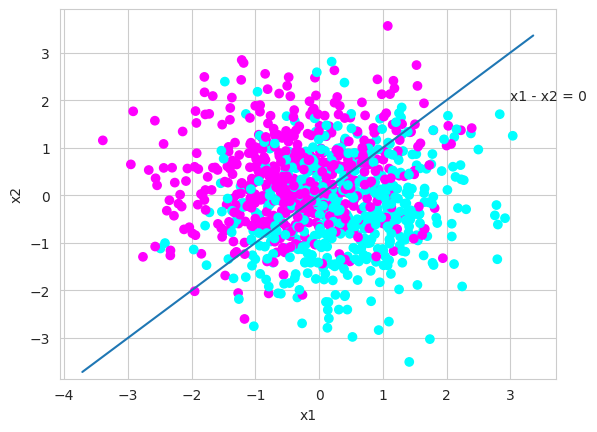

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="cool")
plt.xlabel("x1")
plt.ylabel("x2")
ylim = plt.ylim()
print(ylim)

# Guesstimate a separation boundary
plt.plot(plt.xlim(), np.array(plt.xlim()))
plt.ylim(*ylim)
_ = plt.text(3,2,"x1 - x2 = 0")

In [ ]:
class GradientDescentLogisticRegression:
    def __init__(self):
        pass

    def fit(self, X, y, verbose=True):
        Theta = dict()
        Theta[0] = np.array([[4.],
                             [4.]])#np.zeros((X.shape[1], 1)) #sane starting Theta

        alpha=1e-3
        for t in range(1000):
          #the essential part of the loop
          Theta[t+1] = Theta[t] - alpha*grad(Theta[t], X, y)

          #print stuff from time to time
          if (verbose) and (t % 100 == 0):
            print("Iter", t,"\t\tTheta:", Theta[t].flatten(), "loss:", loss(Theta[t], X, y))

          #convergence criterion
          if np.linalg.norm(Theta[t+1] - Theta[t])  < 1e-4:
            break

        if(verbose):
            print("Iter", t,"\t\tTheta:", Theta[t].flatten(), "loss:", loss(Theta[t], X, y))
        self.ThetaOpt = Theta[t+1]
        self.Theta_hist = np.asarray([Theta[it] for it in range(t)])

    def predict(self, X):
        return np.round(sigmoid(X @ self.ThetaOpt))


In [ ]:
lr_model = GradientDescentLogisticRegression()

In [ ]:
lr_model.fit(X,y)

Iter 0 		Theta: [4. 4.] loss: [2408.12054437]
Iter 69 		Theta: [-0.87297007  0.87351976] loss: [561.53917023]


In [ ]:
lr_model.ThetaOpt

array([[-0.87290608],
       [ 0.87344793]])

In [ ]:
# Make an animation of training

fig = plt.figure()
ax = plt.axes()
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="cool")
plt.xlim([-4.0, 4.0])
plt.ylim([-2.0, 4.0])
plt.xlabel("x1")
plt.ylabel("x2")
# Guesstimate a separation boundary
plt.plot(plt.xlim(), np.array(plt.xlim()))
#plt.ylim(*ylim)
_ = plt.text(3,2,"x1 - x2 = 0")

xlim = np.array(plt.xlim())
ylim = plt.ylim()

line, = plt.plot([],[])

plt.close()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    epoch = 1 + int(1.0 * (len(lr_model.Theta_hist)-1) / num_frames * i)
    Theta = lr_model.Theta_hist[epoch]
    ax.set_title('Epoch %d, Theta: %s' % (epoch, Theta,))
    yy = ( xlim * Theta[0]) / - Theta[1]
    line.set_data(xlim, yy)
    return line,

num_frames=100
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30, blit=True)
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

## visualizing gradient descent in the parameter space

Remember the ground truth $\Theta$ is $(-1,1)$. And $\Theta$ found by our algorithm is:

In [ ]:
lr_model.ThetaOpt

array([[-0.87290608],
       [ 0.87344793]])

In [ ]:
delta = 0.025
grid_x = np.arange(-5.0, 5.0, delta)
grid_y = np.arange(-5.0, 5.0, delta)
grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
grid_Z = np.zeros(grid_X.shape)

In [ ]:
for xit in range(len(grid_x)):
    for yit in range(len(grid_y)):
        grid_Theta = np.array([[grid_x[len(grid_x)-1-xit]],[grid_y[len(grid_y)-1-yit]]])
        grid_Z[xit,yit] = loss( grid_Theta, X, y)[0]

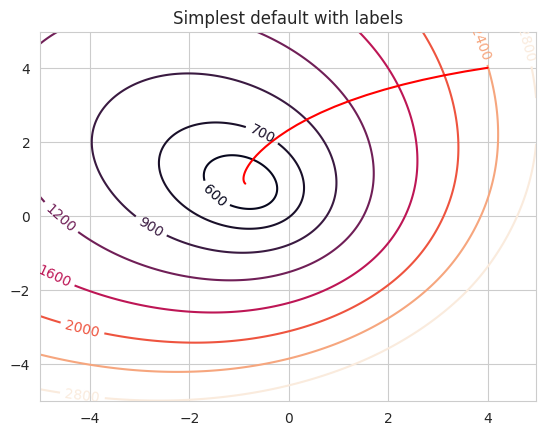

In [ ]:
fig, ax = plt.subplots()
CS = ax.contour(grid_x, grid_y, grid_Z, levels=[550, 600,700,900, 1200, 1600, 2000, 2400, 2800])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Simplest default with labels')

ax.plot(lr_model.Theta_hist[:, 0], lr_model.Theta_hist[:, 1], color="r")

# Problem [3p]

Do the same for the polynomial Ridge regression with degree equal to 44.

**Problem 1 [1p]** Calculate the gradients of the loss function $J_{\mbox{reg}}(\Theta) = \frac{1}{N}\sum_{i=1}^N (y^{(i)} - x^{(i)}\Theta)^2 +  \frac{\alpha}{N} \sum_j \Theta_j^2$, i.e., provide the calculations in the markdown below. You can either do it in LaTeX or you can insert a reasonably good looking photo of your calculations on a sheet of paper.

**Problem 2 [2p]** Implement the gradient descent that calculates $\Theta_{\text{OPT}}$.

**Problem 3 [1p]** Generate a test set using the same distribution as the training set. Then find alpha which minimizes the test error. Precision of alpha has to be up to 0.01 / 1e-2.



**Problem 1 solution**

Gradient of the loss function $J(\Theta)$ with reflect to $\Theta$ will be a vector when the $j^{th}$ element is given by:

$\frac{dJ(\Theta)}{d\Theta_J} = \frac{-2}{N} \sum_{i=1}^{N} (y_i - x_i(\Theta))x_j^i + \frac{2\alpha}{N} \Theta_j$

$x_j^i$ -> $j^{th}$ feature of $i^{th}$ sample.

In vectorized form, it can be written as:

$ΔJ(\Theta) = \frac{-2}{N} x^T(y - X\Theta) + \frac{2α}{N} Θ$

**Problem 2 solution**

In [ ]:
#
# The true polynomial relation:
# y(x) = 1 + 2x -5x^2 + 4x^3
#

true_poly_theta = np.array(
    [1.0, 2.0, -5, 4]
)

def powers_of_X(X, degree):
    powers = np.arange(degree + 1).reshape(1, -1)
    return X ** powers


def compute_polynomial(X, Theta):
    XP = powers_of_X(X, len(Theta) - 1)
    Y = XP @ Theta.reshape(-1, 1)
    return Y

def make_dataset(N, theta=true_poly_theta, sigma=0.1):
    """ Sample a dataset """
    X = np.random.uniform(size=(N, 1))
    Y_clean = compute_polynomial(X, theta)
    Y = Y_clean + np.random.randn(N, 1) * sigma
    return X, Y



np.random.seed(0)
train_data = make_dataset(30)


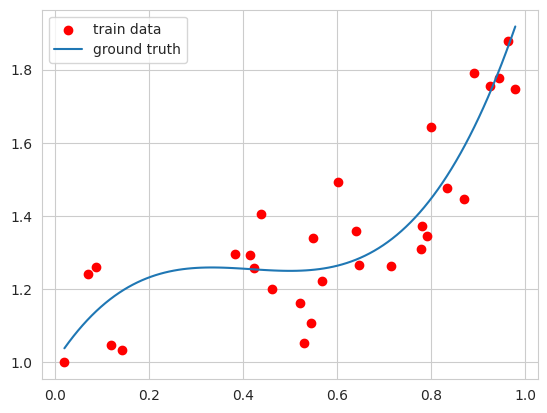

In [ ]:
XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)
YY = compute_polynomial(XX, true_poly_theta)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.legend(loc="upper left")

In [ ]:
X, y = train_data[0], train_data[1]

In [1]:
#TODO the only cell you need to fill with code in this assignment
# NOTE: I've applied the formulas but I still have a problem with my code. Deadline has arrived so I could not find a time to construct a working code.

class GradientDescentPolyRidgeRegression:
    def __init__(self, deg, alpha):
        self.deg = deg
        self.alpha = alpha

    def loss(self, Theta, X, y):
        N = len(y)
        loss = (1 / N) * np.sum((y - X @ Theta) ** 2)

        reg_term = (alpha / N) * np.sum(Theta ** 2)

        return loss + reg_term

    def grad(self, Theta, X, y):
        N = len(y)
        grad = (-(2/N) * (X.T @ (y - X @ Theta)) + (((2 * self.alpha) / N) * Theta))

        return grad

    def fit(self, X, y, verbose=True):
        X_poly = powers_of_X(X, self.deg)
        Theta[0] = np.zeros((X_poly.shape[1], 1))

        for t in range(1000):
            Theta[t+1] = Theta[t] - self.alpha * self.grad(Theta[t], X_poly, y)

            # Print stuff from time to time
            if verbose and t % 100 == 0:
                print("Iter", t, "\tTheta:", Theta[t].flatten(), "loss:", self.loss(Theta[t], X_poly, y))

            # Convergence criterion
            if np.linalg.norm(Theta[t+1] - Theta[t]) < 1e-4:
                break

        if verbose:
            print("Iter", t, "\tTheta:", Theta[t].flatten(), "loss:", self.loss(Theta[t], X_poly, y))
        self.ThetaOpt = Theta[t+1]
        self.Theta_hist = np.asarray([Theta[it] for it in range(t)])

    def predict(self, X):
        return compute_polynomial(X, self.ThetaOpt)

In [ ]:
def mse(y_true, y_pred):
    return ((y_pred - y_true)**2).mean()

Note that without regularization (alpha=0) results are not terribly reliable. But we okay with that:

Iter 0 	Theta: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] loss: 1.9097322580514027
Iter 0 	Theta: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] loss: 1.9097322580514027
MSE: 1.9097322580514027


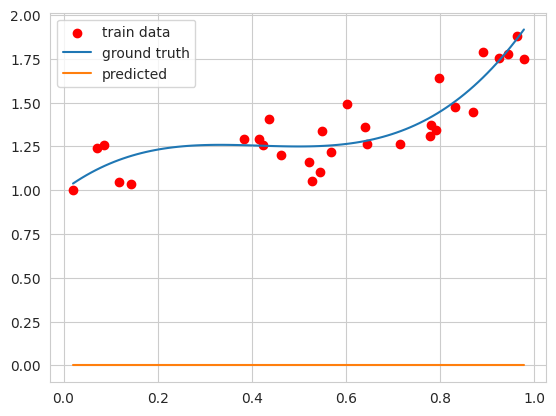

In [ ]:
polyridge_model = GradientDescentPolyRidgeRegression(deg=50, alpha=0)
polyridge_model.fit(X,y, verbose=True)
y_pred = polyridge_model.predict(X)
print("MSE:",mse(y, y_pred))

XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.plot(XX, polyridge_model.predict(XX), label="predicted")
plt.legend(loc="upper left")

With regularization it's much better:

Iter 0 	Theta: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] loss: 1.9097322580514027
Iter 100 	Theta: [-3.69198869e+80 -2.68299947e+80 -2.18116005e+80 -1.85674053e+80
 -1.62621412e+80 -1.45240005e+80 -1.31542729e+80 -1.20378351e+80
 -1.11040137e+80 -1.03071522e+80 -9.61636655e+79 -9.00990028e+79
 -8.47188404e+79 -7.99039912e+79 -7.55627386e+79 -7.16230717e+79
 -6.80274974e+79 -6.47294628e+79 -6.16908174e+79 -5.88799675e+79
 -5.62705067e+79 -5.38401791e+79 -5.15700841e+79 -4.94440573e+79
 -4.74481832e+79 -4.55704091e+79 -4.38002345e+79 -4.21284615e+79
 -4.05469909e+79 -3.90486563e+79 -3.76270874e+79 -3.62765963e+79
 -3.49920839e+79 -3.37689608e+79 -3.26030814e+79 -3.14906882e+79
 -3.04283643e+79 -2.94129933e+79 -2.84417243e+79 -2.75119432e+79
 -2.66212462e+79 -2.57674180e+79 -2.49484128e+79 -2.41623371e+79
 -2.34074348e+79 -2.26820749e+79 -2.19847391e+79 -2.13140125e+79
 -2.06

<ipython-input-225-e1f262773d8e>:10: RuntimeWarning: overflow encountered in square
  loss = (1 / N) * np.sum((y - X @ Theta) ** 2)
<ipython-input-225-e1f262773d8e>:12: RuntimeWarning: overflow encountered in square
  reg_term = (alpha / N) * np.sum(Theta ** 2)
<ipython-input-225-e1f262773d8e>:18: RuntimeWarning: overflow encountered in matmul
  grad = (-(2/N) * (X.T @ (y - X @ Theta)) + (((2 * self.alpha) / N) * Theta))
<ipython-input-225-e1f262773d8e>:27: RuntimeWarning: invalid value encountered in subtract
  Theta[t+1] = Theta[t] - self.alpha * self.grad(Theta[t], X_poly, y)


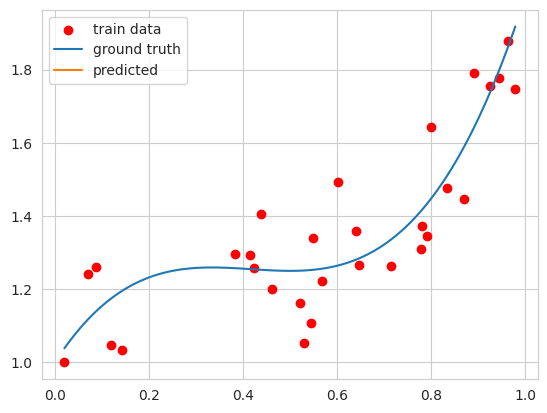

In [ ]:
polyridge_model = GradientDescentPolyRidgeRegression(deg=50, alpha=1.44)
polyridge_model.fit(X,y, verbose=True)
y_pred = polyridge_model.predict(X)
print("MSE:",mse(y, y_pred))

XX = np.linspace(train_data[0].min(), train_data[0].max(), 100).reshape(-1, 1)
plt.scatter(train_data[0], train_data[1], label="train data", color="r")
plt.plot(XX, compute_polynomial(XX, true_poly_theta), label="ground truth")
plt.plot(XX, polyridge_model.predict(XX), label="predicted")
plt.legend(loc="upper left")

**Problem 3 solution**

In [ ]:
# here
# NOTE: This part is how to find best performed alpha value. It is working but since there is a problem with my GradientDescent class, the results may not be correct!

np.random.seed(0)
test_data = make_dataset(30)
alpha_range = np.arange(0, 1, 0.01)

X, y = test_data[0], test_data[1]

best_alpha = None
best_test_error = float('inf')

for alpha in alpha_range:
    model = GradientDescentPolyRidgeRegression(deg=50, alpha=alpha)
    model.fit(X, y, verbose=False)
    predictions = model.predict(X)
    test_error = mse(y, predictions)

    if test_error < best_test_error:
        best_test_error = test_error
        best_alpha = alpha

print("Best alpha:", best_alpha)
print("Test error with best alpha:", best_test_error)

<ipython-input-198-894e5fccdaa1>:2: RuntimeWarning: overflow encountered in square
  return ((y_pred - y_true)**2).mean()
<ipython-input-225-e1f262773d8e>:18: RuntimeWarning: overflow encountered in matmul
  grad = (-(2/N) * (X.T @ (y - X @ Theta)) + (((2 * self.alpha) / N) * Theta))
<ipython-input-225-e1f262773d8e>:27: RuntimeWarning: invalid value encountered in subtract
  Theta[t+1] = Theta[t] - self.alpha * self.grad(Theta[t], X_poly, y)


Best alpha: 0.07
Test error with best alpha: 0.011875442353154452
